In [ ]:
!pip install yfinance
!pip install PyPortfolioOpt 
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.3 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 61 kB 3.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 5.2 MB/s 
     |████████████████████████████████| 9.8 MB 40.2 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pypfopt import risk_models, plotting, expected_returns, objective_functions, EfficientFrontier, CLA
from pypfopt import black_litterman
from pypfopt.black_litterman import BlackLittermanModel
from pypfopt.efficient_frontier import EfficientFrontier
import copy
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pmd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# 1.Portfolio Optimization

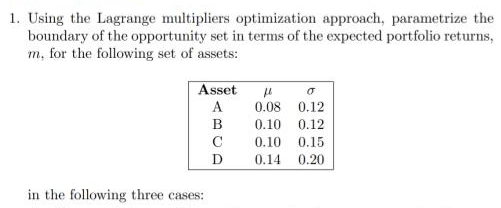

จากโจทย์กำหนดให้มี 4 assets (A,B,C,D) โดยมีการกำหนดให้ μ คือ return vector และ Standard deviation vector โดยสามารถกำหนดเป็นรูปเเบบของ vector โดยใช้ numpy สร้าง metric ที่เป็น diagonal เพื่อให้พร้อมต่อการคำนวณ

In [ ]:
mu = np.array([0.08, 0.10, 0.10, 0.14]).reshape(4,1)
std = np.array([0.12, 0.12, 0.15, 0.20]).reshape(4,1)

mu_diag = np.diag([0.08, 0.10, 0.10, 0.14])
std_diag = np.diag([0.12, 0.12, 0.15, 0.20])

In [ ]:
mu

array([[0.08],
       [0.1 ],
       [0.1 ],
       [0.14]])

In [ ]:
std

array([[0.12],
       [0.12],
       [0.15],
       [0.2 ]])

In [ ]:
# DIAGONAL MU (RETURNS)
mu_diag

array([[0.08, 0.  , 0.  , 0.  ],
       [0.  , 0.1 , 0.  , 0.  ],
       [0.  , 0.  , 0.1 , 0.  ],
       [0.  , 0.  , 0.  , 0.14]])

In [ ]:
# DIAGONAL STD
std_diag

array([[0.12, 0.  , 0.  , 0.  ],
       [0.  , 0.12, 0.  , 0.  ],
       [0.  , 0.  , 0.15, 0.  ],
       [0.  , 0.  , 0.  , 0.2 ]])

In [ ]:
def lagrange_method (cov, R, mu, std, m):
  # RETURN VECTOR AND STD VECTOR RETURN
  mu = np.array(mu).reshape(4,1)
  std = np.array(std).reshape(4,1)

  # RETURN DIAGONAL VECTOR AND STD DIAGONAL VECTOR 
  mu_diag = np.diag(mu)
  std_diag = np.diag(std)

  # COVARIANCE METRIC
  cov = np.matmul(std_diag, R)
  cov = np.matmul(cov, std_diag)

  # INVERSE-COVARIANCE METRIC
  cov_inv = np.linalg.inv(cov)

  # FIND A
  A = np.dot(np.ones((1,4)), cov_inv)
  A = np.dot(A, np.ones((4,1)))
  A = A[0][0]

  # FIND B
  B = np.dot(mu.T, cov_inv)
  B = np.dot(B, np.ones((4,1)))
  B = B[0][0]

  #FIND C
  C = np.dot(mu.T, cov_inv)
  C = np.dot(C, mu)
  C = C[0][0]

  # FIND LAMBDA & GAMMA
  ld = (A*m - B) / (A*C - B**2)
  gm = (C - B*m) / (A*C - B**2)

  # FINALLY, FIND OPTIMAL WEIGHT
  opt_weight = np.dot(cov_inv, (ld*mu + gm*np.ones((4,1))))

  return opt_weight

## A. The correlation coefficients betweem the four assets are given by

จาก correlation matrix จะทำให้เห็นว่า่ asset เเต่ละตัวมีความสัมพันธ์ที่ไปทางเดียวกันเป็นส่วนมาก มีเพียง Asset A เเละ B ที่มีค่า correlation ที่ค่อนข้างน้อย เมื่อเทียบกับความสัมพันธ์ของ asset อื่นๆ

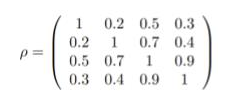

In [ ]:
R1 = np.array([[1, 0.2, 0.5, 0.3], [0.2, 1, 0.7, 0.4], [0.5, 0.7, 1, 0.9], [0.3, 0.4, 0.9, 1]])
R1

array([[1. , 0.2, 0.5, 0.3],
       [0.2, 1. , 0.7, 0.4],
       [0.5, 0.7, 1. , 0.9],
       [0.3, 0.4, 0.9, 1. ]])

สร้าง covariance matrix จากการ dot std vector กับ Correlation matrix โดยมีสูตรดังนี้

สร้าง diagonal matrix สำหรับนำไปคูณกับ Correlation เพื่อหา Covariance

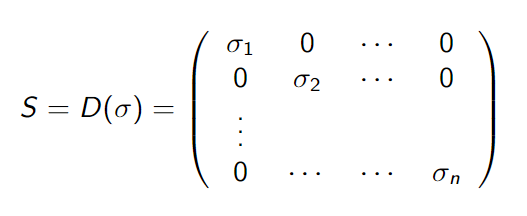

สร้าง Correlation matrix 

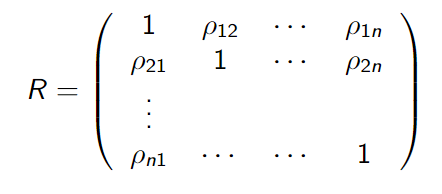

โดยจะหา Covariance matrix จากการ dot กัน (cov = SRS)

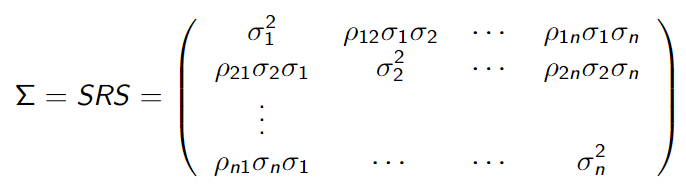

In [ ]:
cov = np.matmul(std_diag, R1)
cov = np.matmul(cov, std_diag)
cov

array([[0.0144 , 0.00288, 0.009  , 0.0072 ],
       [0.00288, 0.0144 , 0.0126 , 0.0096 ],
       [0.009  , 0.0126 , 0.0225 , 0.027  ],
       [0.0072 , 0.0096 , 0.027  , 0.04   ]])

ทำการหา inverse covariance โดยใช้ numpy.linalg มาทำการหา หรืออีกวิธีหนึ่งคือหาได้จากสูตร

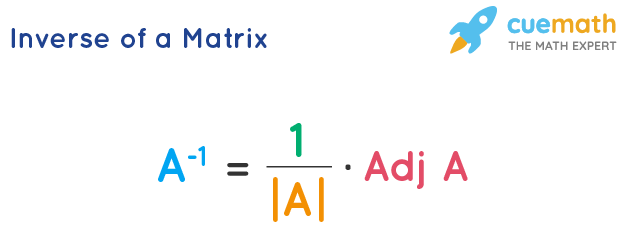

In [ ]:
cov_inv = np.linalg.inv(cov)
cov_inv

array([[  442.83413849,   634.05797101, -1336.55394525,   670.28985507],
       [  634.05797101,  1207.7294686 , -2342.99516908,  1177.53623188],
       [-1336.55394525, -2342.99516908,  4882.44766506, -2492.75362319],
       [  670.28985507,  1177.53623188, -2492.75362319,  1304.34782609]])

ถัดมาเป็นการคำนวนณหา inverse ของ Covariance matrix เพื่อนำมาคำนวณหาค่่ A, B, C เพื่อไปคำนวณหาค่า labmda เเละ gamma ต่อไป

โดยจากการ derive สูตรต่างๆ จะได้สูตรที่หาค่า parameter ต่างๆ ได้จากสูตรดังต่อไปนี้

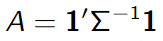



1.   โดยที่ Σ คือ Covariance matrix กำลัง -1 เเสดงว่าเป็นการทำ inverse
2.   1 เป็น matrix ที่มีเพียงค่า 1 โดยmatrix 1 ตัวเเรกที่มีการทำ transpose จะมีมิติเป็น 1*n เเละตัวถัดมาจะมีมิติเป็น n*1 เพื่อที่หลังจาก cross product กันเเล้วจะได้ผลลัพธ์ออกมาเป็นตัวเลขเพียงค่าเดียว



In [ ]:
A = np.dot(np.ones((1,4)), cov_inv)
A = np.dot(A, np.ones((4,1)))
A = A[0][0]
A

456.52173913043043

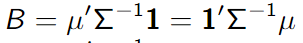

In [ ]:
B = np.dot(mu.T, cov_inv)
B = np.dot(B, np.ones((4,1)))
B = B[0][0]
B

63.816425120772465

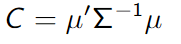

In [ ]:
C = np.dot(mu.T, cov_inv)
C = np.dot(C, mu)
C = C[0][0]
C

9.389694041867886

กำหนดให้ m เป็น expected return โดยในโปรเเกรมนี้จะขอ assume ว่า m=10% โดยจะนำ m, A, B, C มาเพื่อคำนวณหาค่า lambda เเละ gamma จากสูตรดังต่อไปนี้



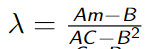

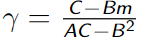

In [ ]:
m = 0.1

ld = (A*m - B) / (A*C - B**2)
gm = (C - B*m) / (A*C - B**2)

In [ ]:
ld

-0.08485456369107734

In [ ]:
gm

0.014052156469408845

In [ ]:
opt_weight = np.dot(cov_inv, (ld*mu + gm*np.ones((4,1))))
opt_weight

array([[ 0.76228686],
       [ 0.84419926],
       [-0.98762956],
       [ 0.38114343]])

In [ ]:
sum(opt_weight)

array([1.])

จาก lagrange method ที่ทำเพื่อหวังกำไร 10 %  ทำให้เห็นได้ว่าเมื่อเราทำการ sum weight จะได้ค่า weight รวมเท่ากับ 1 เเละทำให้เราสามารถทำการจัด weight ใน portfolio ได้ดังนี้ 


1.   Asset A long ประมาณ 76.23 % ของ portfolio
2.   Asset B long ประมาณ 84.42 % ของ portfolio
3.   Asset C จะเห็นได้ว่าค่า weight ติดลบ ทำให้สามารถคิดได้ว่าเป็นการ short ประมาณ 98.76 % ของ portfolio
4.   Asset D long ประมาณ 38.11 % ของ portfolio



## B. The Correlation coefficients between the four assets are given by

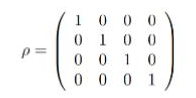

สำหรับในข้อ 1b จาก Correlation matrix จะเห็นได้ว่าความสัมพันธ์ของ asset เเต่ละตัวมีค่าเป็น 0 ทั้งหมด หรืออาจจะสามารถเข้าใจได้ว่า asset เเต่ละตัวไม่มีความสัมพันธ์ของทิศทางราคากันเลย โดยจะสามารถกำหนด correlation matrix ได้ดังนี้

In [ ]:
R2 = np.diag([1,1,1,1])
R2

array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]])

ถัดมาเป็นการคำนวณ covariance matrix เเละ inverse covariance matrix จากสูตรดังต่อไปนี้

In [ ]:
cov2 = np.matmul(std_diag.T, R2)
cov2 = np.matmul(cov2, std_diag)
cov2

array([[0.0144, 0.    , 0.    , 0.    ],
       [0.    , 0.0144, 0.    , 0.    ],
       [0.    , 0.    , 0.0225, 0.    ],
       [0.    , 0.    , 0.    , 0.04  ]])

In [ ]:
cov2_inv = np.linalg.inv(cov2)
cov2_inv

array([[69.44444444,  0.        ,  0.        ,  0.        ],
       [ 0.        , 69.44444444,  0.        ,  0.        ],
       [ 0.        ,  0.        , 44.44444444,  0.        ],
       [ 0.        ,  0.        ,  0.        , 25.        ]])

In [ ]:
A = np.dot(np.ones((1,4)), cov2_inv)
A = np.dot(A, np.ones((4,1)))
A = A[0][0]
A

208.33333333333331

In [ ]:
B = np.dot(mu.T, cov2_inv)
B = np.dot(B, np.ones((4,1)))
B = B[0][0]
B

20.444444444444443

In [ ]:
C = np.dot(mu.T, cov2_inv)
C = np.dot(C, mu)
C = C[0][0]
C

2.0733333333333333

In [ ]:
# DEFINED EXPECTED RETURN M
m = 0.1

# FIND LAMBDA AND GAMMA
ld = (A*m - B) / (A*C - B**2)
gm = (C - B*m) / (A*C - B**2)

print(f'Lambda is {ld:.4f} & Gamma is {gm:.4f}')

Lambda is 0.0278 & Gamma is 0.0021


In [ ]:
opt_weight = np.dot(cov2_inv, (ld*mu + gm*np.ones((4,1))))
opt_weight

array([[0.29827662],
       [0.33694211],
       [0.21564295],
       [0.14913831]])

In [ ]:
sum(opt_weight)

array([1.])

## C. The Correlation coefficients between thhe four assets are given by

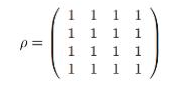

In [ ]:
R3 = np.ones((4,4))
R3

array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]])

In [ ]:
cov3 = np.matmul(std_diag.T, R3)
cov3 = np.matmul(cov3, std_diag)
cov3

array([[0.0144, 0.0144, 0.018 , 0.024 ],
       [0.0144, 0.0144, 0.018 , 0.024 ],
       [0.018 , 0.018 , 0.0225, 0.03  ],
       [0.024 , 0.024 , 0.03  , 0.04  ]])

ติดปัญหาเนื่องจาก metrix ที่เป็นค่า 1 ทั้งหมด เป็น singular matrix ไม่สามารถหาค่า inverse ของ matrix ได้

In [ ]:
# cov3_inv = np.linalg.inv(cov3)
# cov3_inv

# 2.Portfolio Optimization programming

## 2.1 Write a program to read stock data of 5 companies in US market. You can use stocks in SET as well. However, SET closed prices are not adjusted. Thus, the result may not reflect the actual market condition.

ขั้นเเรกเป็นการดึงข้อมูลหุ้นโดยใช้จาก YahooFinance โดยจะกำหนดหุ่นที่นำมาใช้ ได้เเก่ 

1.   AAPL (Apple.Inc)
2.   CCL (Carnival Corporation & plc)
3.   NVDA (NVIDIA Corporation)
4.   AMD (Advanced Micro Devices, Inc.)
5.   AMZN


In [ ]:
ticker = 'AAPL CCL NVDA AMZN AMD'

df_ori = yf.download(ticker, start='2005-01-01',adjust=True)
df = df_ori['Close'].copy()
df.head()

[*********************100%***********************]  5 of 5 completed


,AAPL,AMD,AMZN,CCL,NVDA
Date,,,,,
2005-01-03 00:00:00-05:00,1.130179,21.410000,2.2260,57.310001,1.965000
2005-01-04 00:00:00-05:00,1.141786,20.209999,2.1070,57.049999,1.872500
2005-01-05 00:00:00-05:00,1.151786,19.750000,2.0885,56.950001,1.890000
2005-01-06 00:00:00-05:00,1.152679,19.719999,2.0525,57.360001,1.871667
2005-01-07 00:00:00-05:00,1.236607,19.920000,2.1160,57.500000,1.835833


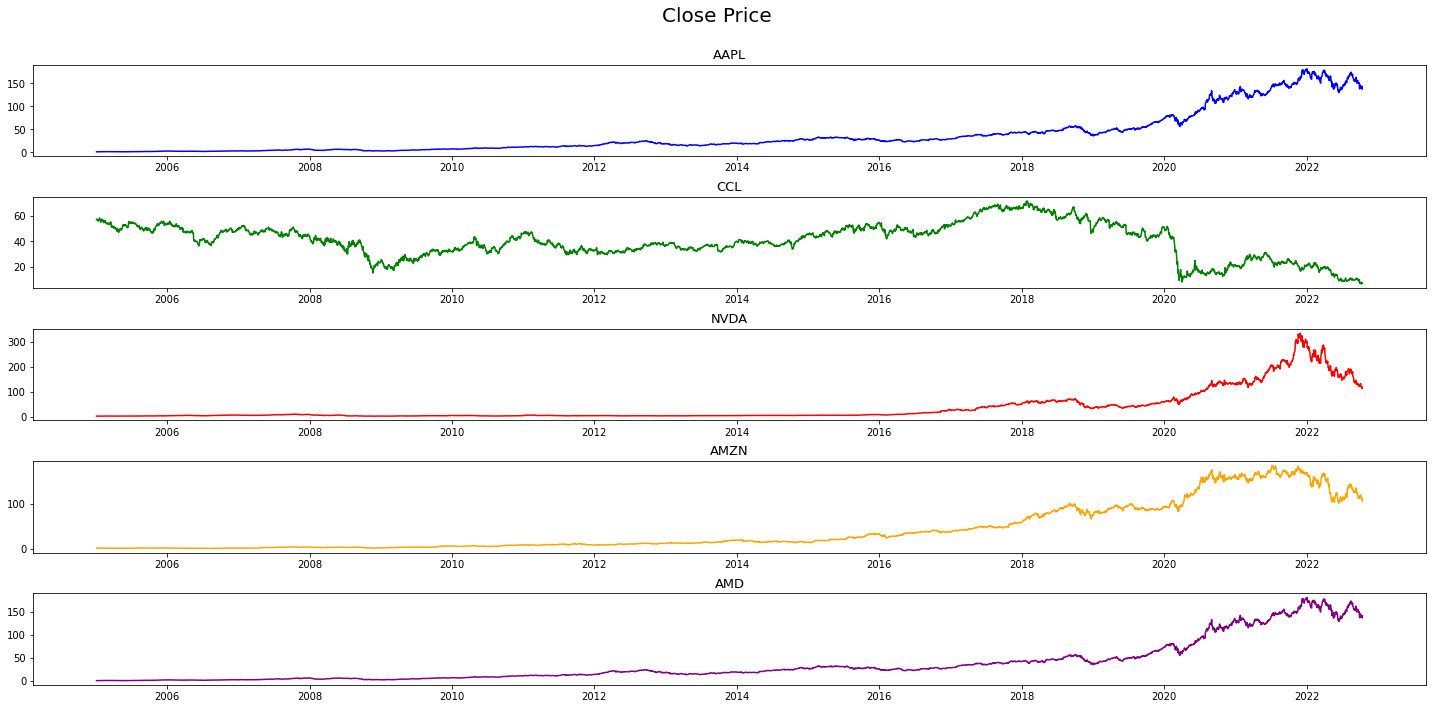

In [ ]:
fig, axes = plt.subplots(nrows=5, figsize=(20,10))

fig.suptitle('Close Price', size=20)

axes[0].plot(df['AAPL'], color='blue')
axes[0].set_title('AAPL', fontsize=13)

axes[1].plot(df.CCL, color='green')
axes[1].set_title('CCL', fontsize=13)

axes[2].plot(df.NVDA, color='red')
axes[2].set_title('NVDA', fontsize=13)

axes[3].plot(df.AMZN, color='orange')
axes[3].set_title('AMZN', fontsize=13)

axes[4].plot(df.AAPL, color='purple')
axes[4].set_title('AMD', fontsize=13)

plt.tight_layout()
fig.subplots_adjust(top=0.9)
plt.show()

## 2.2 Evaluate and plot rolling VaR and expected shortfall of these stock. Use 1-day and 99% confident interval.

สำหรับขั้นเเรกคือการคำนวณค่า returns โดยจะคำนวณ daily return จากสูตร (Pt+1 - Pt) / Pt 

In [ ]:
df['AAPL_returns'] = df['AAPL'].pct_change()
df['AMD_returns'] = df['AMD'].pct_change()
df['AMZN_returns'] = df['AMZN'].pct_change()
df['CCL_returns'] = df['CCL'].pct_change()
df['NVDA_returns'] = df['NVDA'].pct_change()

df.tail()

,AAPL,AMD,AMZN,CCL,NVDA,AAPL_returns,AMD_returns,AMZN_returns,CCL_returns,NVDA_returns
Date,,,,,,,,,,
2022-10-10 00:00:00-04:00,140.419998,57.810001,113.669998,6.38,116.699997,0.002356,-0.010780,-0.007769,-0.056213,-0.033620
2022-10-11 00:00:00-04:00,138.979996,57.630001,112.209999,6.64,115.860001,-0.010255,-0.003114,-0.012844,0.040752,-0.007198
2022-10-12 00:00:00-04:00,138.339996,57.849998,112.900002,7.31,115.000000,-0.004605,0.003817,0.006149,0.100904,-0.007423
2022-10-13 00:00:00-04:00,142.990005,58.939999,112.529999,7.10,119.599998,0.033613,0.018842,-0.003277,-0.028728,0.040000
2022-10-14 00:00:00-04:00,138.380005,55.939999,106.900002,7.13,112.269997,-0.032240,-0.050899,-0.050031,0.004225,-0.061288


จากนั้นทำการคำนวณค่า Value at Risk โดยจะใช้วิธีการ Historical VaR คือการที่คำนวณค่า VaR จากข้อมูลในอดีต โดยจะคำนวณตำเเหน่งของค่า VaR จาก 1% เเรกจำนวนข้อมูลที่ผ่านการ sort มาเเล้ว

In [ ]:
def compute_percentile(j):
  j = j.sort_values()
  # CONFIDENT INTERVAL
  conf_interval = 0.01
  
  # COMPUTE FIRST 1% OF DATA
  num = int(round(len(j)* conf_interval, 0))

  # DEFINE TIME INTERVAL
  time_interval = 1 

  # COMPUTE 1-DAY VAR
  VaR_1d = j.iloc[num] * np.sqrt(time_interval)
  #print(j.iloc[num])   
        
  return VaR_1d

สำหรับการทำงานของ function compute_percentile ที่สร้างขึ้นมาเพื่อคำนวณค่าจาก lag ที่มาจากการ rolling จะมีการทำงานดังนี้


1.   ทำการ sort data จาก lag ที่ได้รับมาก่อน
2.   จากนัั้นทำการกำหนดค่า conf_interval คือ ค่าที่บ่งบอกว่าจะคำนวณค่า VaR จาก 1% แรกของ Data และกำหนด time_interval ซึ่งเป้นค่าที่จะประมาณ VaR ในอีก n วันข้างหน้า ซึ่งกำหนดว่าเป็น 1 วัน 
3.   คำนวณค่า VaR_1d จากค่า VaR * sqrt(n) 

โดยจะกำหนด rolling ให้มีค่า lag ประมาณ 200 วัน หรือ 1 เดือน



In [ ]:
df['AAPL_VaR'] = df['AAPL_returns'].rolling(200).apply(compute_percentile)
df['AMD_VaR'] = df['AMD_returns'].rolling(200).apply(compute_percentile)
df['AMZN_VaR'] = df['AMZN_returns'].rolling(200).apply(compute_percentile)
df['CCL_VaR'] = df['CCL_returns'].rolling(200).apply(compute_percentile)
df['NVDA_VaR'] = df['NVDA_returns'].rolling(200).apply(compute_percentile)

df.tail()

,AAPL,AMD,AMZN,CCL,NVDA,AAPL_returns,AMD_returns,AMZN_returns,CCL_returns,NVDA_returns,AAPL_VaR,AMD_VaR,AMZN_VaR,CCL_VaR,NVDA_VaR
Date,,,,,,,,,,,,,,,
2022-10-10 00:00:00-04:00,140.419998,57.810001,113.669998,6.38,116.699997,0.002356,-0.010780,-0.007769,-0.056213,-0.033620,-0.055716,-0.094189,-0.07561,-0.111812,-0.092279
2022-10-11 00:00:00-04:00,138.979996,57.630001,112.209999,6.64,115.860001,-0.010255,-0.003114,-0.012844,0.040752,-0.007198,-0.055716,-0.094189,-0.07561,-0.111812,-0.092279
2022-10-12 00:00:00-04:00,138.339996,57.849998,112.900002,7.31,115.000000,-0.004605,0.003817,0.006149,0.100904,-0.007423,-0.055716,-0.094189,-0.07561,-0.111812,-0.092279
2022-10-13 00:00:00-04:00,142.990005,58.939999,112.529999,7.10,119.599998,0.033613,0.018842,-0.003277,-0.028728,0.040000,-0.055716,-0.094189,-0.07561,-0.111812,-0.092279
2022-10-14 00:00:00-04:00,138.380005,55.939999,106.900002,7.13,112.269997,-0.032240,-0.050899,-0.050031,0.004225,-0.061288,-0.055716,-0.094189,-0.07561,-0.111812,-0.092279


โดยค่าที่ได้ออกมาจะเป็นค่า VaR-1day ที่คำนวณมาจาก historical return ของ stock เเต่ละตัว 

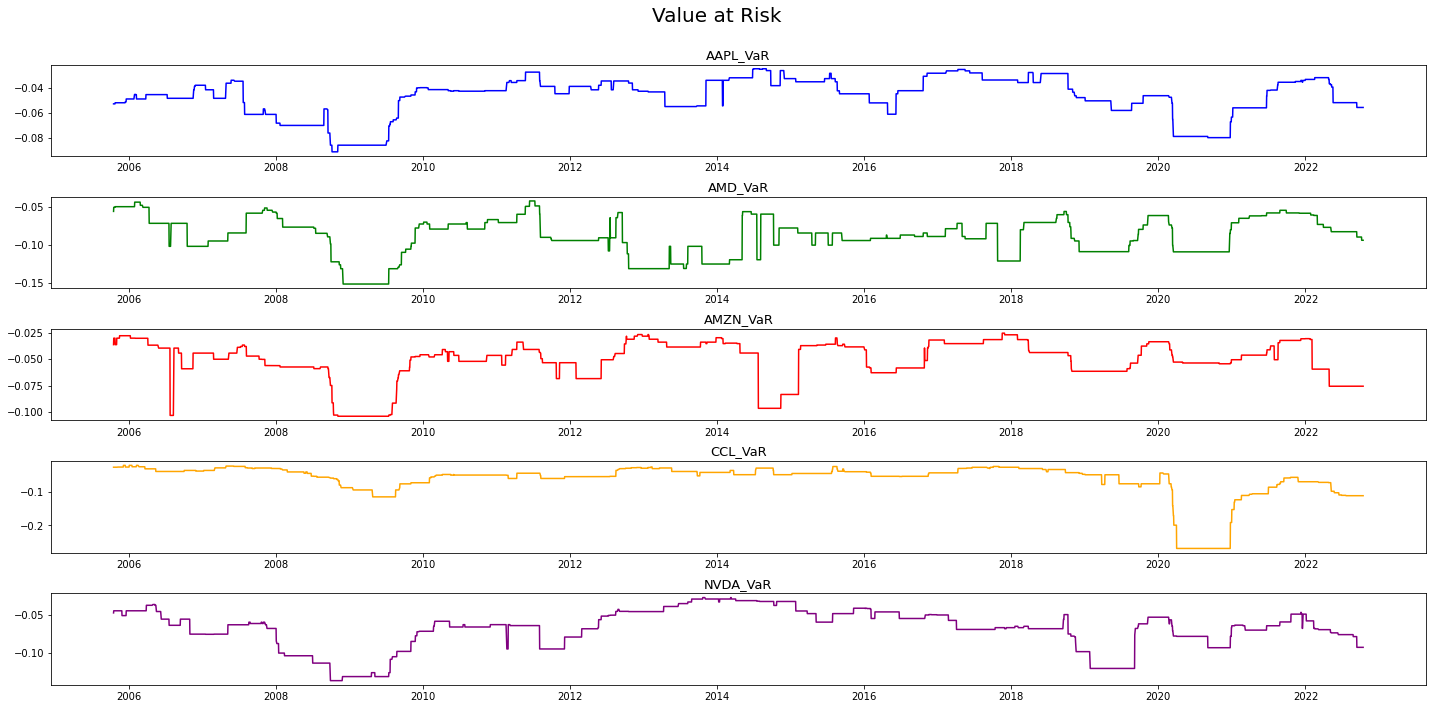

In [ ]:
fig, axes = plt.subplots(nrows=5, figsize=(20,10))

fig.suptitle('Value at Risk', size=20)

axes[0].plot(df.AAPL_VaR, color='blue')
axes[0].set_title('AAPL_VaR', fontsize=13)

axes[1].plot(df.AMD_VaR, color='green')
axes[1].set_title('AMD_VaR', fontsize=13)

axes[2].plot(df.AMZN_VaR, color='red')
axes[2].set_title('AMZN_VaR', fontsize=13)

axes[3].plot(df.CCL_VaR, color='orange')
axes[3].set_title('CCL_VaR', fontsize=13)

axes[4].plot(df.NVDA_VaR, color='purple')
axes[4].set_title('NVDA_VaR', fontsize=13)

plt.tight_layout()
fig.subplots_adjust(top=0.9)
plt.show()

ถัดมาเป็นการคำนวณ expected shortfall คือ จะคำนวณค่าเฉลี่ยทั้งหมดของจำนวนที่มีค่าตั้งเเต่ cutoff ของ VaR ตยถึงค่าที่ต่ำที่สุดของ historical

In [ ]:
def compute_esf(j):
  j = j.sort_values()
  # CONFIDENT INTERVAL
  conf_interval = 0.01
  
  # COMPUTE FIRST 1% OF DATA
  num = int(round(len(j)* conf_interval, 0))

  # DEFINE TIME INTERVAL
  time_interval = 1 
  
    # COMPUTE 1-DAY VAR
  esf_1d = j[:num].mean() * np.sqrt(1)
  #print(j.iloc[num])   
        
  return esf_1d

In [ ]:
df['AAPL_esf'] = df['AAPL_returns'].rolling(200).apply(compute_esf)
df['AMD_esf'] = df['AMD_returns'].rolling(200).apply(compute_esf)
df['AMZN_esf'] = df['AMZN_returns'].rolling(200).apply(compute_esf)
df['CCL_esf'] = df['CCL_returns'].rolling(200).apply(compute_esf)
df['NVDA_esf'] = df['NVDA_returns'].rolling(200).apply(compute_esf)

การทำงานของ algorithm คล้ายกับ rolling VaR เเต่ว่าจากที่ใช้ค่าที่ cutoff มาคูณ sqrt(n) จะใช้เป็นค่าเฉลี่ยของ ค่าต่ำสุดจนถึง cutoff เเทน

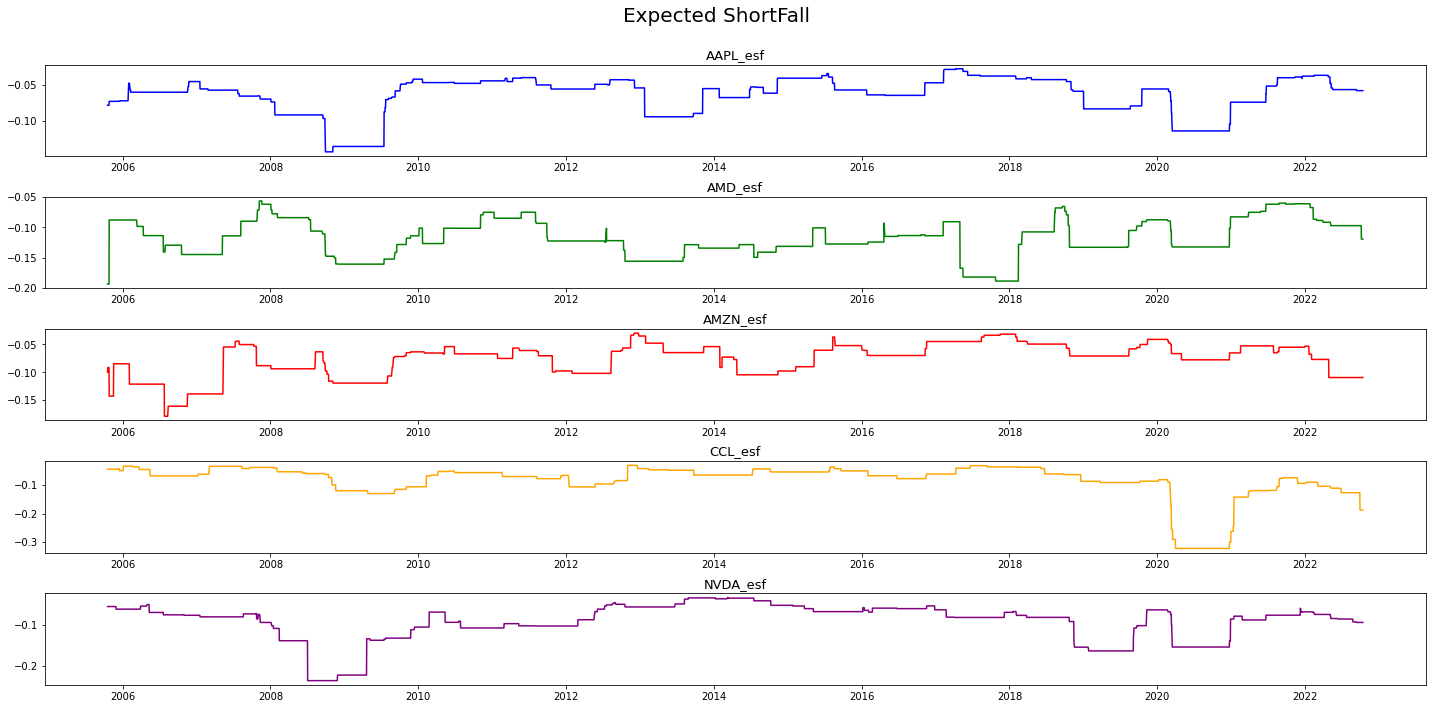

In [ ]:
fig, axes = plt.subplots(nrows=5, figsize=(20,10))

fig.suptitle('Expected ShortFall', size=20)

axes[0].plot(df.AAPL_esf, color='blue')
axes[0].set_title('AAPL_esf', fontsize=13)

axes[1].plot(df.AMD_esf, color='green')
axes[1].set_title('AMD_esf', fontsize=13)

axes[2].plot(df.AMZN_esf, color='red')
axes[2].set_title('AMZN_esf', fontsize=13)

axes[3].plot(df.CCL_esf, color='orange')
axes[3].set_title('CCL_esf', fontsize=13)

axes[4].plot(df.NVDA_esf, color='purple')
axes[4].set_title('NVDA_esf', fontsize=13)

plt.tight_layout()
fig.subplots_adjust(top=0.9)
plt.show()

## 2.3 Perform portfolio optimization (finding weights) based on the following objective function.

สำหรับ mean-variance optimization จะใช้ PyPortfolioOpt ในการช่วย solve หา optimal weight โดยขั้นเเรกจะเป็นการคำนวณ covariance ของ prices ใน stock เเต่ละตัวก่อน

In [ ]:
sample_cov = risk_models.sample_cov(df_ori['Close'])
sample_cov

,AAPL,AMD,AMZN,CCL,NVDA
AAPL,0.109022,0.072912,0.058766,0.051259,0.075352
AMD,0.072912,0.341372,0.074637,0.079639,0.143120
AMZN,0.058766,0.074637,0.147981,0.057393,0.078049
CCL,0.051259,0.079639,0.057393,0.211424,0.076911
NVDA,0.075352,0.143120,0.078049,0.076911,0.232638


หลังจากทำการคำนวณ Covariance matrix เสร็นเรียบร้อยเเล้ว ทำการคำนวณ expected return จาก mean historical return ต่อ หรือคือการคำนวณค่าเฉลี่ยของ return จากข้อมูลในอดีต

In [ ]:
mu = expected_returns.return_model(df_ori['Close'], method='mean_historical_return')
mu

AAPL    0.310764
AMD     0.055548
AMZN    0.243498
CCL    -0.110693
NVDA    0.255717
dtype: float64

จากกราฟจะพบว่า return ส่วนมากจะเป็น return ที่กำไร เเต่จะมีเพียง CCL ที่เป็นติดลบหรือขาดทุน

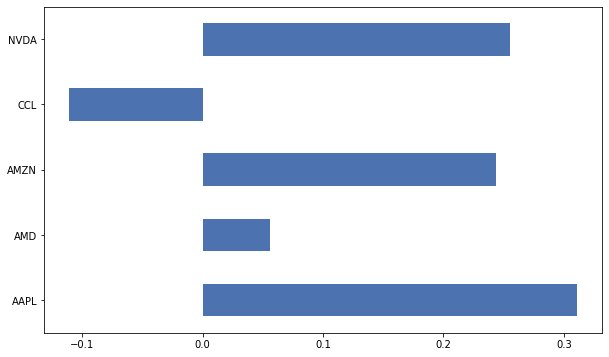

In [ ]:
mu.plot.barh(figsize=(10,6))

### lambda = 0.5

In [ ]:
ef = EfficientFrontier(mu, sample_cov, weight_bounds=(None, None))
ef.max_quadratic_utility(risk_aversion=0.5, market_neutral=False)
weights = ef.clean_weights()
weights

OrderedDict([('AAPL', 1.0),
             ('AMD', -1.0),
             ('AMZN', 1.0),
             ('CCL', -1.0),
             ('NVDA', 1.0)])

จากผลการตั้ง lambda=0.5 จะพบว่าได้ผลลัพธ์ของค่า weight ที่เป็นน้ำหนักในการลงทุนของ asset เเต่ละตัว ได้ดังนี้

1.   AAPL long 100 %
2.   AMD short 100 %
3.   AMZN long 100 %
4.   CCL short 100 % 
5.   NVDA long 100 %

โดยในกรณีนี้เมื่อ sum weight เเล้วอาจจะไม่ได้มีค่าเป็น 1 เนื่องจากไม่ได้กำหนด market_neutral = True



โดย performance ต่างๆ ของ portfolio จะมีค่าดังนี้

In [ ]:
ef.portfolio_performance(verbose=True)

Expected annual return: 86.5%
Annual volatility: 82.1%
Sharpe Ratio: 1.03


(0.8651246523847016, 0.8207225845985407, 1.029732419022071)

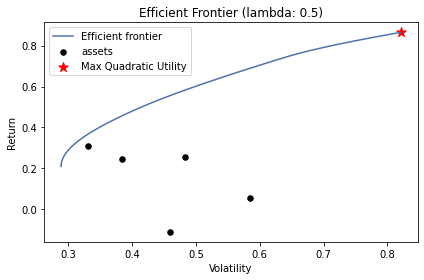

In [ ]:
ef = EfficientFrontier(mu, sample_cov, weight_bounds=(None, None))

fig, ax = plt.subplots()
ef_max_quad = copy.deepcopy(ef)
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)

# Find the tangency portfolio
ef_max_quad.max_quadratic_utility(risk_aversion=0.5)
ret_tangent, std_tangent, _ = ef_max_quad.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Quadratic Utility")

# Output
ax.set_title("Efficient Frontier (lambda: 0.5)")
ax.legend()
plt.tight_layout()
plt.show()

### lambda = 1.2

In [ ]:
ef = EfficientFrontier(mu, sample_cov, weight_bounds=(None, None))
ef.max_quadratic_utility(risk_aversion=1.2, market_neutral=False)
weights = ef.clean_weights()
weights

OrderedDict([('AAPL', 1.0),
             ('AMD', -0.49609),
             ('AMZN', 0.82037),
             ('CCL', -1.0),
             ('NVDA', 0.67572)])

จากผลการตั้ง lambda=1.2 จะพบว่าได้ผลลัพธ์ของค่า weight ที่เป็นน้ำหนักในการลงทุนของ asset เเต่ละตัว ได้ดังนี้

1.   AAPL long 100 %
2.   AMD short ~ 49.60 %
3.   AMZN long ~ 82.03 %
4.   CCL short 100 % 
5.   NVDA long ~ 67.57 %

โดยในกรณีนี้เมื่อ sum weight เเล้วอาจจะไม่ได้มีค่าเป็น 1 เนื่องจากไม่ได้กำหนด market_neutral = True




โดย performance ต่างๆ ของ portfolio จะมีค่าดังนี้

In [ ]:
ef.portfolio_performance(verbose=True)

Expected annual return: 76.6%
Annual volatility: 66.7%
Sharpe Ratio: 1.12


(0.7664526040266255, 0.6666364577670992, 1.1197296447405092)

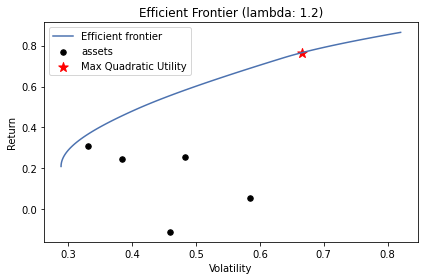

In [ ]:
ef = EfficientFrontier(mu, sample_cov, weight_bounds=(None, None))

fig, ax = plt.subplots()
ef_max_quad = copy.deepcopy(ef)
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)

# Find the tangency portfolio
ef_max_quad.max_quadratic_utility(risk_aversion=1.2)
ret_tangent, std_tangent, _ = ef_max_quad.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Quadratic Utility")

# Output
ax.set_title("Efficient Frontier (lambda: 1.2)")
ax.legend()
plt.tight_layout()
plt.show()

### lambda = 2.3

In [ ]:
ef = EfficientFrontier(mu, sample_cov, weight_bounds=(None, None))
ef.max_quadratic_utility(risk_aversion=2.3, market_neutral=False)
weights = ef.clean_weights()
weights

OrderedDict([('AAPL', 1.0),
             ('AMD', -0.24879),
             ('AMZN', 0.52543),
             ('CCL', -0.63132),
             ('NVDA', 0.35469)])

จากผลการตั้ง lambda=2.3 จะพบว่าได้ผลลัพธ์ของค่า weight ที่เป็นน้ำหนักในการลงทุนของ asset เเต่ละตัว ได้ดังนี้

1.   AAPL long 100 %
2.   AMD short ~ 24.88 %
3.   AMZN long ~ 52.54 %
4.   CCL short 63.13 % 
5.   NVDA long ~ 35.46 %

โดยในกรณีนี้เมื่อ sum weight เเล้วอาจจะไม่ได้มีค่าเป็น 1 เนื่องจากไม่ได้กำหนด market_neutral = True


โดย performance ต่างๆ ของ portfolio จะมีค่าดังนี้

In [ ]:
ef.portfolio_performance(verbose=True)

Expected annual return: 58.5%
Annual volatility: 48.5%
Sharpe Ratio: 1.17


(0.5854684725781972, 0.48534665148231537, 1.1650816397953478)

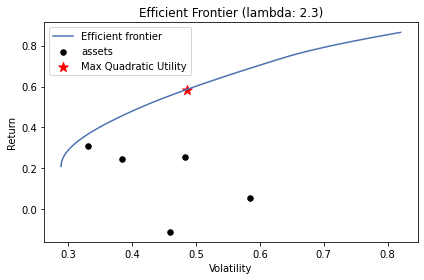

In [ ]:
ef = EfficientFrontier(mu, sample_cov, weight_bounds=(None, None))

fig, ax = plt.subplots()
ef_max_quad = copy.deepcopy(ef)
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)

# Find the tangency portfolio
ef_max_quad.max_quadratic_utility(risk_aversion=2.3)
ret_tangent, std_tangent, _ = ef_max_quad.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Quadratic Utility")

# Output
ax.set_title("Efficient Frontier (lambda: 2.3)")
ax.legend()
plt.tight_layout()
plt.show()

## 2.4 Plot efficient frontier of each case. Analyze and describe the results.

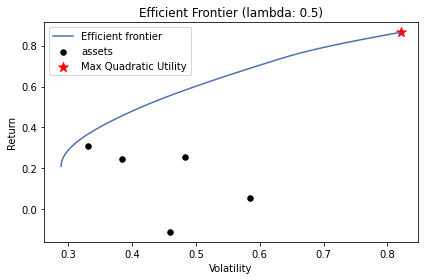

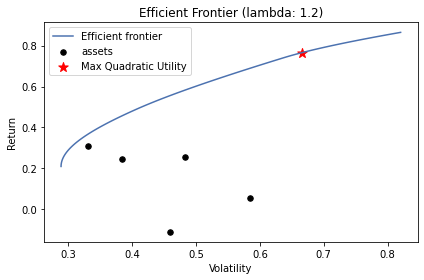

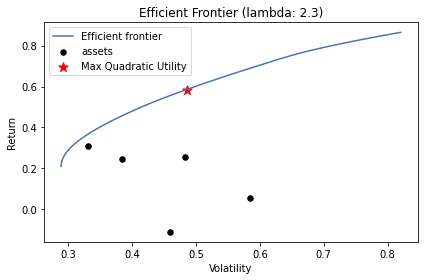

จากการเปลี่ยนค่า lambda จะพบว่าทั้งค่า return เเละ volatility มีค่าที่ลดลง ดังนี้
*   ค่า lambda มาก  ->  return น้อย, volatility น้อย
*   ค่า lambda น้อย  ->  return มาก, volatility มาก

หากย้อนกลับไปดู การกำหนดค่า lambda = 0.5 จะเห็นได้ว่าเป็นการลงทุนเเบบเต็มจำนวนให้กับเเต่ละ asset ไปเลย ซึ่งมีความเสี่ยงที่ค่อนข้างสูง เเละหากยิ่งเพิ่มค่า lambda การกระจายความเสียงดดยการลงทุนใน asset ที่หลากหลายจะเพิ่มมากขึ้น
สรุปได้ว่า หากต้องการ return ที่สูง ก็ต้องยอมรับ Risk ที่สูงตามไปด้วย โดยสามารถปรับได้จาก ค่า lambda 


## 2.5 Use Black-Litterman technique for portfolio optimization with the same data. You can create a view matrix of an analysist by yourself. Use at least 3 views.

คำนวณ mcaps ของ asset เเต่ละตัว 

In [ ]:
mcaps = {'AAPL' : yf.Ticker('AAPL').info['marketCap'],
          'AMD' : yf.Ticker('AMD').info['marketCap'],
          'AMZN' : yf.Ticker('AMZN').info['marketCap'],
          'CCL' : yf.Ticker('CCL').info['marketCap'],
          'NVDA' : yf.Ticker('NVDA').info['marketCap']
}

mcaps

{'AAPL': 2223877390336,
 'AMD': 90305060864,
 'AMZN': 1089054441472,
 'CCL': 9260587008,
 'NVDA': 279776821248}

In [ ]:
sample_cov

,AAPL,AMD,AMZN,CCL,NVDA
AAPL,0.109022,0.072912,0.058766,0.051259,0.075352
AMD,0.072912,0.341372,0.074637,0.079639,0.143120
AMZN,0.058766,0.074637,0.147981,0.057393,0.078049
CCL,0.051259,0.079639,0.057393,0.211424,0.076911
NVDA,0.075352,0.143120,0.078049,0.076911,0.232638


กำหนด tau โดย tau จะมีค่า 1 / จำนวน data โดย data ทั้งหมดมี 4478 วัน

In [ ]:
tau = 1 / 4478

กำหนด views โดยการ assume ขึ้นมา ดังนี้
 

1.   CCL ให้ return -30%
2.   NVDA ให้ return สูงกว่า AMZN 20%
3.   AMZN ให้ return สูงกว่า CCL 10%

ต่อจากนั้นทำการสร้าง matrix P และ  Vector Q ขึ้นมา โดยจะมีค่าดังนี้

*   Vector Q = [-0.30, 0.20, 0.10]
*   Matrix P = [[0, 0, 0, -1, 0], [0, 0, -1, 0, 1], [0, 0, 1, -1, 0]]




In [ ]:
Q = np.array([-0.3, 0.2, 0.1]).reshape(-1, 1)

P = np.array([[0, 0, 0, -1, 0], [0, 0, -1, 0, 1], [0, 0, 1, -1, 0]])

ต่อมาเป็นการคำนวณ prior ซึ่งสามารถคำนวณได้จากสูตรต่อไปนี้

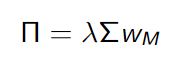

เราสามารถหาได้จาก pyportop library โดยใช้ parameters mcaps, lamb(risk aversion) เเละ covariance matrix โดย Risk aversion (lambda) ก็สามารถคำนวณได้จาก pyportop โดยใช้คำสั่ง market_implied_risk_aversion(asset_price)

In [ ]:
tickers = ['AAPL', 'AMD', 'AMZN', 'CCL', 'NVDA']
lamb = black_litterman.market_implied_risk_aversion(df[['AAPL', 'AMD', 'AMZN', 'CCL', 'NVDA']])
prior = black_litterman.market_implied_prior_returns(mcaps, lamb, sample_cov)

จากนั้นคำนวณ omega จากสูตร

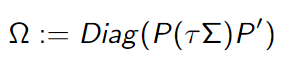

In [ ]:
omega = np.array(np.matmul(np.matmul(P,tau*sample_cov), P.transpose()))
omega = np.diagflat(omega.diagonal())
omega

array([[4.72138523e-05, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 5.01384521e-05, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 5.46267393e-05]])

สุดท้ายคือการนำ parameter ต่างๆ ที่หามา เข้า BlackLitterModel โดย parameter ที่ต้องใส่เข้าไปได้เเก่ covariance matrix, จำนวน assets, tickers, Q vector, P matrix, omega เเละ tau เเล้วก็จะได้ optimal weight ที่คำนวณมาจาก BlackLitterModel

In [ ]:
bl = BlackLittermanModel(cov_matrix=sample_cov, n_assets=5, tickers=tickers, Q=Q, P=P, pi=prior, omega=omega, tau=tau)

rets = bl.bl_returns()
ef = EfficientFrontier(rets, sample_cov)

bl.bl_weights(lamb.values)
weights = bl.clean_weights()

weights

OrderedDict([('AAPL', 0.68425),
             ('AMD', -0.39754),
             ('AMZN', 0.07854),
             ('CCL', 0.39265),
             ('NVDA', 0.2421)])

# 3.Time-Series modeling

In [ ]:
ticker = 'AAPL CCL GOOG AMZN AMD'

df_ori = yf.download(ticker, start='2005-01-01', end='2019-01-01',adjust=True)
df = df_ori['Close'].copy()
df.head()

[*********************100%***********************]  5 of 5 completed


,AAPL,AMD,AMZN,CCL,GOOG
Date,,,,,
2005-01-03 00:00:00-05:00,1.130179,21.410000,2.2260,57.310001,5.048826
2005-01-04 00:00:00-05:00,1.141786,20.209999,2.1070,57.049999,4.844342
2005-01-05 00:00:00-05:00,1.151786,19.750000,2.0885,56.950001,4.819685
2005-01-06 00:00:00-05:00,1.152679,19.719999,2.0525,57.360001,4.696148
2005-01-07 00:00:00-05:00,1.236607,19.920000,2.1160,57.500000,4.828153


## 3.1 Check seasonality, trends, and stationarity.  

In [ ]:
def check_adfuller(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("Reject the null hypothesis. Data is stationary")
    else:
        print("Do not reject the null hypothesis. Data is not stationary ")

In [ ]:
check_adfuller(df['AAPL'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -0.6987321791510674
p-value : 0.8470776588020812
#Lags Used : 29
Number of Observations Used : 3493
Do not reject the null hypothesis. Data is not stationary 


In [ ]:
check_adfuller(df['AMD'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -1.9627416151892285
p-value : 0.3031446415053032
#Lags Used : 25
Number of Observations Used : 3497
Do not reject the null hypothesis. Data is not stationary 


In [ ]:
check_adfuller(df['AMZN'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : 0.9728435467551682
p-value : 0.993970989732842
#Lags Used : 30
Number of Observations Used : 3492
Do not reject the null hypothesis. Data is not stationary 


In [ ]:
check_adfuller(df['CCL'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -2.127270973142472
p-value : 0.2336911158737064
#Lags Used : 2
Number of Observations Used : 3520
Do not reject the null hypothesis. Data is not stationary 


In [ ]:
check_adfuller(df['GOOG'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : 0.1104415565175899
p-value : 0.9667667993033323
#Lags Used : 29
Number of Observations Used : 3493
Do not reject the null hypothesis. Data is not stationary 


จะเห็นได้ว่าจากการกำหนด hypothesis ว่าหากค่า P-value ต่ำกว่า 0.05 จะ reject hypothesis เเละมีความเป็น Stationary จากการเช็ค adfuller พบว่าไม่มีตัวไหนที่ต่ำกว่า 0.05 เลย 

In [ ]:
df.head()

,AAPL,AMD,AMZN,CCL,GOOG
Date,,,,,
2005-01-03 00:00:00-05:00,1.130179,21.410000,2.2260,57.310001,5.048826
2005-01-04 00:00:00-05:00,1.141786,20.209999,2.1070,57.049999,4.844342
2005-01-05 00:00:00-05:00,1.151786,19.750000,2.0885,56.950001,4.819685
2005-01-06 00:00:00-05:00,1.152679,19.719999,2.0525,57.360001,4.696148
2005-01-07 00:00:00-05:00,1.236607,19.920000,2.1160,57.500000,4.828153


<Figure size 432x288 with 0 Axes>

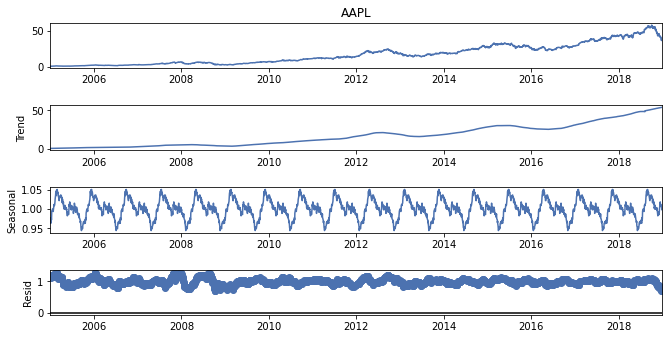

In [ ]:
result = seasonal_decompose(df['AAPL'], model='multiplicative', extrapolate_trend='freq', period=200)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(10, 5)

<Figure size 432x288 with 0 Axes>

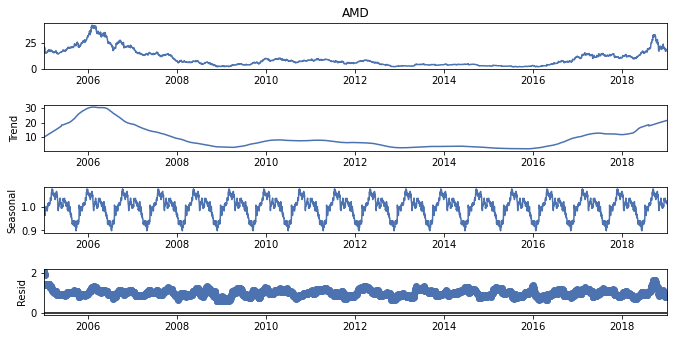

In [ ]:
result = seasonal_decompose(df['AMD'], model='multiplicative', extrapolate_trend='freq', period=200)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(10, 5)

<Figure size 432x288 with 0 Axes>

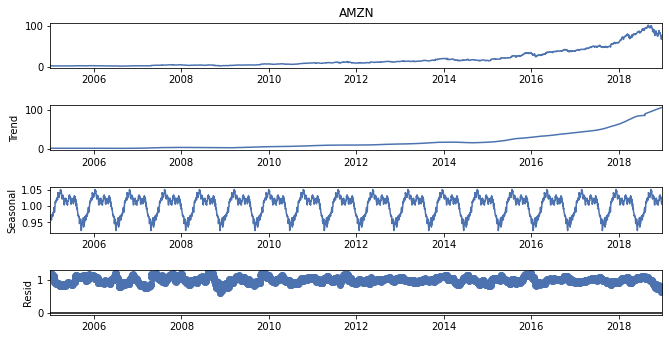

In [ ]:
result = seasonal_decompose(df['AMZN'], model='multiplicative', extrapolate_trend='freq', period=200)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(10, 5)

<Figure size 432x288 with 0 Axes>

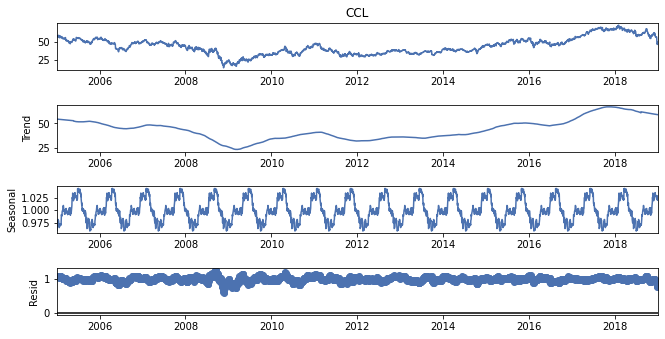

In [ ]:
result = seasonal_decompose(df['CCL'], model='multiplicative', extrapolate_trend='freq', period=200)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(10, 5)

<Figure size 432x288 with 0 Axes>

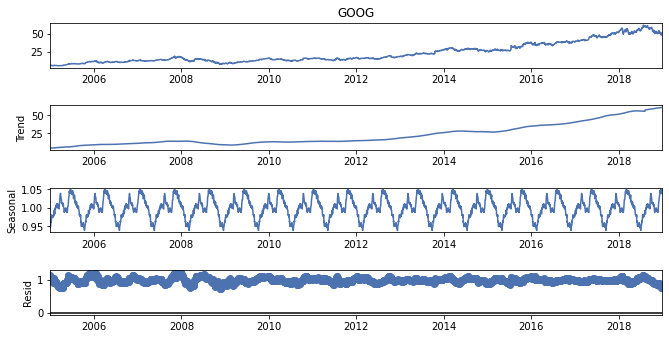

In [ ]:
result = seasonal_decompose(df['GOOG'], model='multiplicative', extrapolate_trend='freq', period=200)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(10, 5)

จะสังเกตได้ว่าข้อมูลยังมีความเป็น trend, seasonal เเละ stationarity อยู่ด้วย จริงๆ เเล้วหากข้อมูลมีความเป็น stationarity จะไม่มีความเป็น trend จึงจะต้องทำการ diff เพื่อลดความเป็น stationarity

In [ ]:
df['AAPL_1diff'] = df['AAPL'] - df['AAPL'].shift(1)
df['AMD_1diff'] = df['AMD'] - df['AMD'].shift(1)
df['AMZN_1diff'] = df['AMZN'] - df['AMZN'].shift(1)
df['CCL_1diff'] = df['CCL'] - df['CCL'].shift(1)
df['GOOG_1diff'] = df['GOOG'] - df['GOOG'].shift(1)

In [ ]:
check_adfuller(df['AAPL_1diff'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -9.614685112872943
p-value : 1.7733433730716682e-16
#Lags Used : 30
Number of Observations Used : 3491
Reject the null hypothesis. Data is stationary


In [ ]:
check_adfuller(df['AMD_1diff'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -10.902230310715455
p-value : 1.1514966373059077e-19
#Lags Used : 24
Number of Observations Used : 3497
Reject the null hypothesis. Data is stationary


In [ ]:
check_adfuller(df['AMZN_1diff'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -9.65807300611594
p-value : 1.3769260558431095e-16
#Lags Used : 30
Number of Observations Used : 3491
Reject the null hypothesis. Data is stationary


In [ ]:
check_adfuller(df['CCL_1diff'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -43.8172479062453
p-value : 0.0
#Lags Used : 1
Number of Observations Used : 3520
Reject the null hypothesis. Data is stationary


In [ ]:
check_adfuller(df['GOOG_1diff'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -11.037890136285283
p-value : 5.458603369516504e-20
#Lags Used : 30
Number of Observations Used : 3491
Reject the null hypothesis. Data is stationary


ภายหลังจากการใช้ diff เเล้วพบว่า data มีความเป็น staionary ทุกตัว เเล้วนอกจากนี้ยังเป็นการลบ trend ออกจาก data อีกด้วย

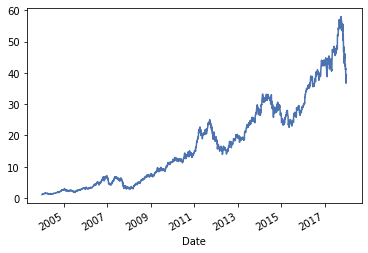

In [ ]:
df['AAPL'].plot()

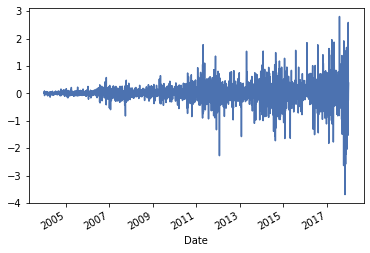

In [ ]:
df['AAPL_1diff'].plot()

## 3.2 Implement ARIMA models to predict 5 stocks that you choose. You may use 2019 data for testing and earlier data for training. You could use ACF or PACF to determine the order of the model.

สำหรับการเเบ่ง data จะใช้ข้อมูลตั้งเเต่ปี 2015-2018 ในการ train เเละ ใช้ชุดข้อมูลในอาทิตย์เเรกของปี 2019 ในการทดสอบ

### AAPL

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


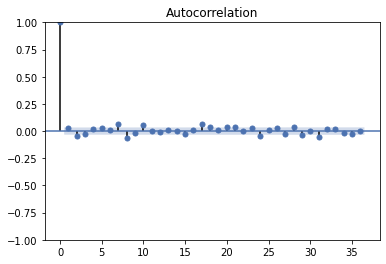

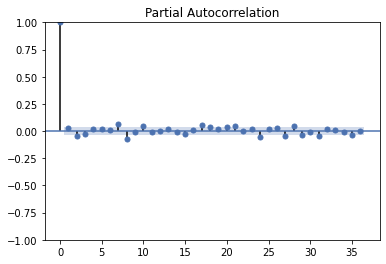

In [ ]:
fig = plot_acf(df['AAPL_1diff'].dropna())
fig = plot_pacf(df['AAPL_1diff'].dropna())

จะเห็นได้ว่า 1 diff เมื่อ plot ดู acf เเละ pacf อาจจะทำให้ไม่เห็นภาพที่ชัดมากนักว่าระดับเวลาไหนถึงจะเกินนัยสำคัญได้อย่างเหมาะสม จึงควรทำ diff อีกครั้งเพื่อให้เห็นภาพที่ชัดเจนมากยิ่งขึ้น

In [ ]:
df['AAPL_2diff'] = df['AAPL_1diff'] - df['AAPL_1diff'].shift(1)
df['AMD_2diff'] = df['AMD_1diff'] - df['AMD_1diff'].shift(1)
df['AMZN_2diff'] = df['AMZN_1diff'] - df['AMZN_1diff'].shift(1)
df['CCL_2diff'] = df['CCL_1diff'] - df['CCL_1diff'].shift(1)
df['GOOG_2diff'] = df['GOOG_1diff'] - df['GOOG_1diff'].shift(1)

สังเกตว่าหลังจาก diff รอบที่ 2 จะสามารถอ่านค่าได้ง่ายขึ้นมาก โดยจะทำ 2 diff กับทุกๆ หุ้น

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


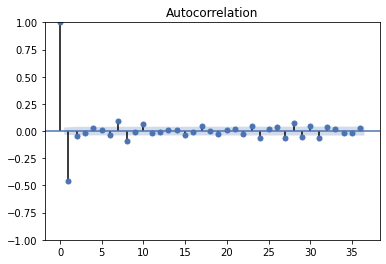

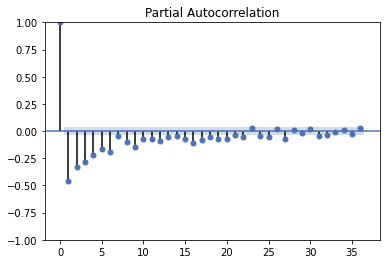

In [ ]:
fig = plot_acf(df['AAPL_2diff'].dropna())
fig = plot_pacf(df['AAPL_2diff'].dropna())

ค่า p เเละ q ที่เป็น parameter จากใน ARIMA โดย p เป็นจำนวนของ autoregressive term สามารถดูค่าที่เหมาะสมได้ด้วย pacf เเละ q คือ lagged forecast errors ในโมเดล สามารถหาค่าที่เหมาะสมได้จาก acf เเละ d คือ จำนวนครั้งที่ทำการ diff 

โดยจะทำการเเบ่ง data ออกเป็น train เเละ test โดย train จะใช้เวลาตั้งเเต่ปี 2015 ถึง 2018 

In [ ]:
n_days = 7

train = df['AAPL'][:-n_days]
test = df['AAPL'][-n_days:]

In [ ]:
def arimamodel(timeseriesarray):
    autoarima_model = pmd.auto_arima(timeseriesarray, 
                              start_p=1, 
                              start_q=1,
                              d=2,
                              test="adf",
                              trace=True)
    return autoarima_model

In [ ]:
model = arimamodel(train)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=2.26 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=4882.325, Time=0.18 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=4031.202, Time=0.11 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=1.42 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=3631.513, Time=0.38 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=3329.050, Time=0.54 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=3170.413, Time=0.65 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=3067.310, Time=0.79 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=6.98 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=5.45 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=3069.304, Time=1.82 sec

Best model:  ARIMA(5,2,0)(0,0,0)[0]          
Total fit time: 20.617 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3516
Model:         

จากการทำนายพบว่าค่า p, d, q ที่ optimal ที่สุดวัดจาก Minimum AIC พบว่ามีค่า (5,2,0)

In [ ]:
pred = model.predict(len(test), alpha=0.05)
test = pd.DataFrame(test)
test['predicted'] = np.array(pred)
test

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


,AAPL,predicted
Date,,
2018-12-20 00:00:00-05:00,39.207500,39.811998
2018-12-21 00:00:00-05:00,37.682499,39.422409
2018-12-24 00:00:00-05:00,36.707500,38.914699
2018-12-26 00:00:00-05:00,39.292500,38.479235
2018-12-27 00:00:00-05:00,39.037498,38.065078
2018-12-28 00:00:00-05:00,39.057499,37.488529
2018-12-31 00:00:00-05:00,39.435001,37.026626


ทำการทำนายโดยมีค่านัยยะสำคัญ 95 % โดยทำนายล่วงหน้า 7 วัน

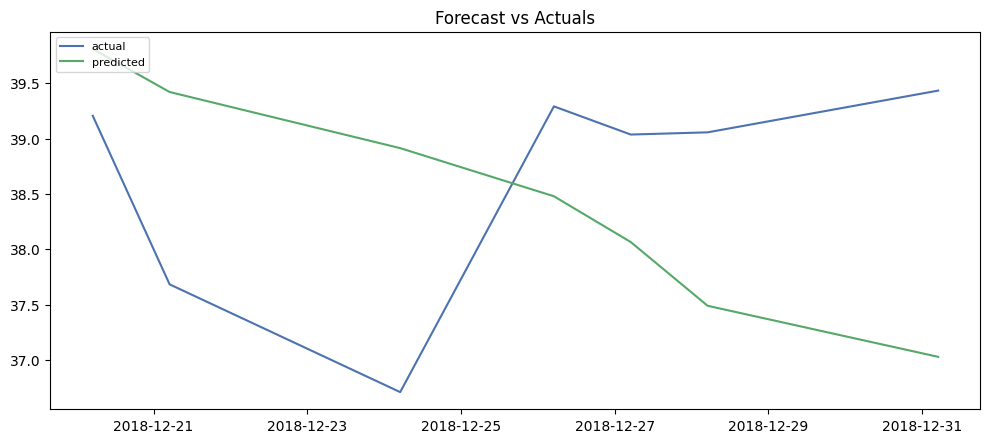

In [ ]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(test['AAPL'], label='actual')
plt.plot(test['predicted'], label='predicted')
# plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()


### AMD

In [ ]:
n_days = 7

train = df['AMD'][:-n_days]
test = df['AMD'][-n_days:]

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


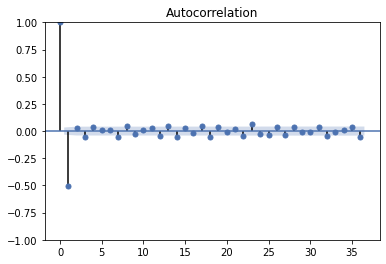

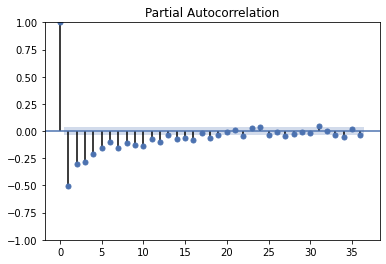

In [ ]:
fig = plot_acf(df['AMD_2diff'].dropna())
fig = plot_pacf(df['AMD_2diff'].dropna())

In [ ]:
model = arimamodel(train)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=1.92 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=6324.251, Time=0.12 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=5278.367, Time=0.11 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.84 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=4936.698, Time=0.31 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=4639.400, Time=0.45 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=4475.970, Time=0.51 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=4394.534, Time=0.72 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=5.12 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=3.23 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=4396.534, Time=2.17 sec

Best model:  ARIMA(5,2,0)(0,0,0)[0]          
Total fit time: 15.524 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3516
Model:         

จากการทำนายพบว่าค่า p, d, q ที่ optimal ที่สุดวัดจาก Minimum AIC พบว่ามีค่า (5,2,0) 

In [ ]:
pred = model.predict(len(test), alpha=0.05)
test = pd.DataFrame(test)
test['predicted'] = np.array(pred)
test

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


,AMD,predicted
Date,,
2018-12-20 00:00:00-05:00,17.940001,17.902355
2018-12-21 00:00:00-05:00,16.930000,17.412203
2018-12-24 00:00:00-05:00,16.650000,17.059691
2018-12-26 00:00:00-05:00,17.900000,16.575089
2018-12-27 00:00:00-05:00,17.490000,16.180618
2018-12-28 00:00:00-05:00,17.820000,15.634199
2018-12-31 00:00:00-05:00,18.459999,15.216597


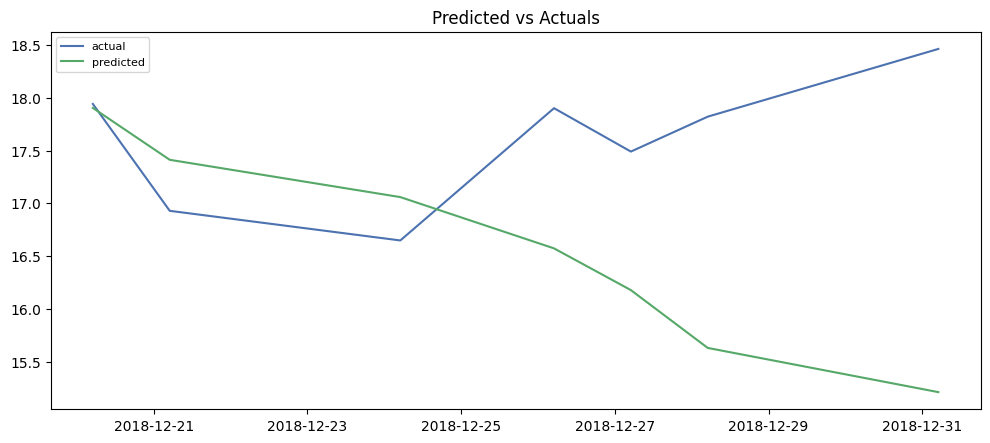

In [ ]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(test['AMD'], label='actual')
plt.plot(test['predicted'], label='predicted')
# plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Predicted vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### AMZN

In [ ]:
n_days = 7

train = df['AMZN'][:-n_days]
test = df['AMZN'][-n_days:]

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


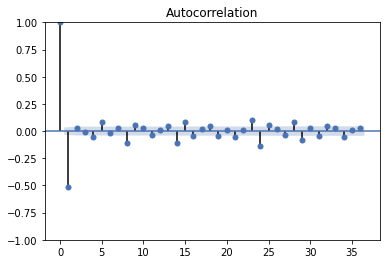

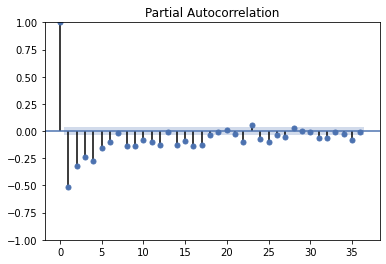

In [ ]:
fig = plot_acf(df['AMZN_2diff'].dropna())
fig = plot_pacf(df['AMZN_2diff'].dropna())

In [ ]:
model = arimamodel(train)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=1.12 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=8513.071, Time=0.25 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=7414.362, Time=0.11 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.85 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=7038.001, Time=0.25 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=6837.623, Time=0.35 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=6597.102, Time=0.47 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=6481.865, Time=0.58 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=2.95 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=2.87 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=6483.842, Time=1.37 sec

Best model:  ARIMA(5,2,0)(0,0,0)[0]          
Total fit time: 11.184 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3516
Model:         

จากการทำนายพบว่าค่า p, d, q ที่ optimal ที่สุดวัดจาก Minimum AIC พบว่ามีค่า (5,2,0)

In [ ]:
pred = model.predict(len(test), alpha=0.05)
test = pd.DataFrame(test)
test['predicted'] = np.array(pred)
test

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


,AMZN,predicted
Date,,
2018-12-20 00:00:00-05:00,73.041496,73.851827
2018-12-21 00:00:00-05:00,68.872498,72.153273
2018-12-24 00:00:00-05:00,67.197998,70.155817
2018-12-26 00:00:00-05:00,73.544998,68.774504
2018-12-27 00:00:00-05:00,73.082001,67.504830
2018-12-28 00:00:00-05:00,73.901001,65.854254
2018-12-31 00:00:00-05:00,75.098503,64.392004


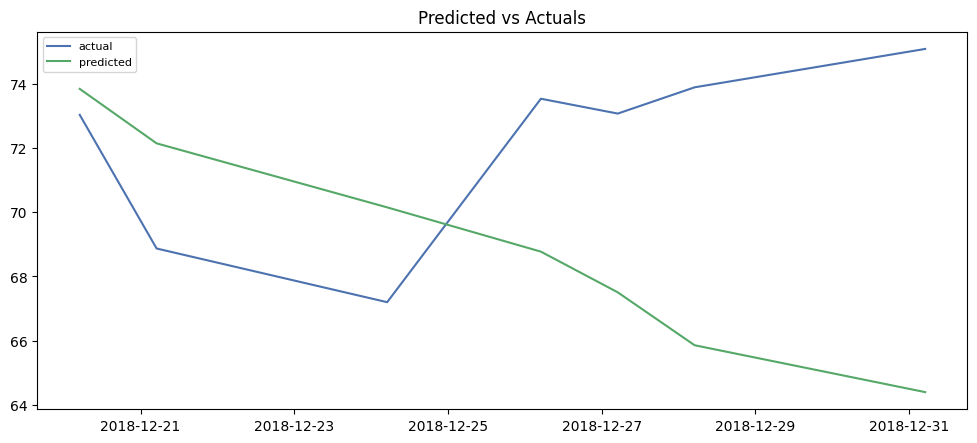

In [ ]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(test['AMZN'], label='actual')
plt.plot(test['predicted'], label='predicted')
# plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Predicted vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### CCL

In [ ]:
n_days = 7

train = df['CCL'][:-n_days]
test = df['CCL'][-n_days:]

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


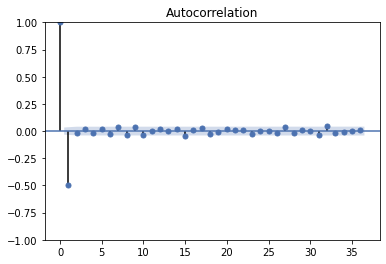

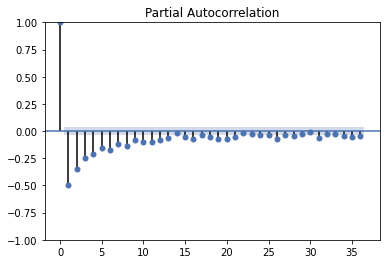

In [ ]:
fig = plot_acf(df['CCL_2diff'].dropna())
fig = plot_pacf(df['CCL_2diff'].dropna())

In [ ]:
model = arimamodel(train)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=1.91 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=10664.982, Time=0.11 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=9679.099, Time=0.13 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.97 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=9212.858, Time=0.27 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=8988.901, Time=0.91 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=8821.792, Time=0.70 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=8731.647, Time=1.42 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=6.93 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=4.96 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=8733.646, Time=1.37 sec

Best model:  ARIMA(5,2,0)(0,0,0)[0]          
Total fit time: 19.716 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3516
Model:        

จากการทำนายพบว่าค่า p, d, q ที่ optimal ที่สุดวัดจาก Minimum AIC พบว่ามีค่า (5,2,0)

In [ ]:
pred = model.predict(len(test), alpha=0.05)
test = pd.DataFrame(test)
test['predicted'] = np.array(pred)
test

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


,CCL,predicted
Date,,
2018-12-20 00:00:00-05:00,49.790001,54.851113
2018-12-21 00:00:00-05:00,47.860001,54.590602
2018-12-24 00:00:00-05:00,46.209999,54.244628
2018-12-26 00:00:00-05:00,47.500000,53.899442
2018-12-27 00:00:00-05:00,48.130001,53.476165
2018-12-28 00:00:00-05:00,48.680000,53.030441
2018-12-31 00:00:00-05:00,49.299999,52.704041


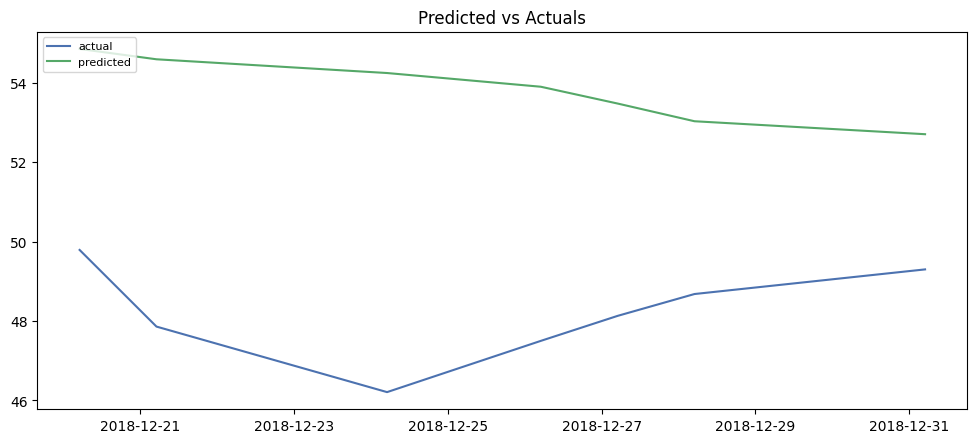

In [ ]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(test['CCL'], label='actual')
plt.plot(test['predicted'], label='predicted')
# plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Predicted vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### GOOG

In [ ]:
n_days = 7

train = df['GOOG'][:-n_days]
test = df['GOOG'][-n_days:]

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


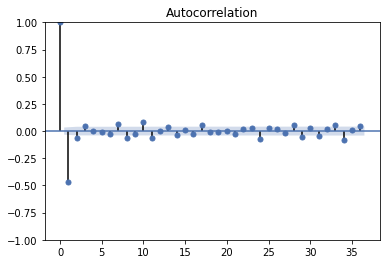

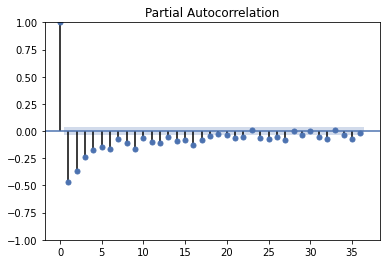

In [ ]:
fig = plot_acf(df['GOOG_2diff'].dropna())
fig = plot_pacf(df['GOOG_2diff'].dropna())

ใน GOOG จะเห็นได้ว่า p ที่เหมาะสมคือ 1 q ที่เหมาะสมคือ 1 เเละ d = 2

In [ ]:
model = arimamodel(train)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=2.04 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=6003.049, Time=0.16 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=5095.845, Time=0.15 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=1.78 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=4602.831, Time=0.36 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=4408.868, Time=0.47 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=4312.938, Time=0.59 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=4235.588, Time=0.74 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=6.98 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=4.76 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=4237.587, Time=1.88 sec

Best model:  ARIMA(5,2,0)(0,0,0)[0]          
Total fit time: 19.939 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3516
Model:         

จากการทำนายพบว่าค่า p, d, q ที่ optimal ที่สุดวัดจาก Minimum AIC พบว่ามีค่า (5,2,0)

In [ ]:
pred = model.predict(len(test), alpha=0.05)
test = pd.DataFrame(test)
test['predicted'] = np.array(pred)
test

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


,GOOG,predicted
Date,,
2018-12-20 00:00:00-05:00,50.470501,50.832434
2018-12-21 00:00:00-05:00,48.977001,50.501077
2018-12-24 00:00:00-05:00,48.811001,50.110610
2018-12-26 00:00:00-05:00,51.973000,49.760061
2018-12-27 00:00:00-05:00,52.194000,49.565313
2018-12-28 00:00:00-05:00,51.854000,49.255119
2018-12-31 00:00:00-05:00,51.780499,48.936324


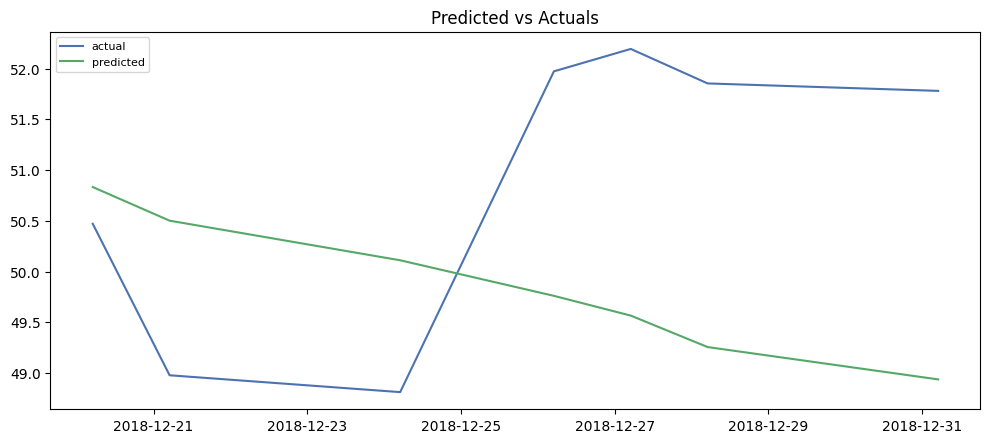

In [ ]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(test['GOOG'], label='actual')
plt.plot(test['predicted'], label='predicted')
# plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Predicted vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## 3.3 Plot historical VAR and cVAR, parametric VAR and cVAR along with historical return. Use 1-day as the criterion.

ขั้นเเรกคือการคำนวณค่า return ของ asset เเต่ละตัว

In [ ]:
df['AAPL_returns'] = df['AAPL'].pct_change()
df['AMD_returns'] = df['AMD'].pct_change()
df['AMZN_returns'] = df['AMZN'].pct_change()
df['CCL_returns'] = df['CCL'].pct_change()
df['GOOG_returns'] = df['GOOG'].pct_change()

หลังจากคำนวณเเล้วก็นำเข้า rolling เเละ compute_percentile function เพื่อคำนวณค่า VaR โดยกำหนดให้คำนวณ lag ละ 200 วัน

In [ ]:
df['AAPL_VaR'] = df['AAPL_returns'].rolling(200).apply(compute_percentile)
df['AMD_VaR'] = df['AMD_returns'].rolling(200).apply(compute_percentile)
df['AMZN_VaR'] = df['AMZN_returns'].rolling(200).apply(compute_percentile)
df['CCL_VaR'] = df['CCL_returns'].rolling(200).apply(compute_percentile)
df['GOOG_VaR'] = df['GOOG_returns'].rolling(200).apply(compute_percentile)

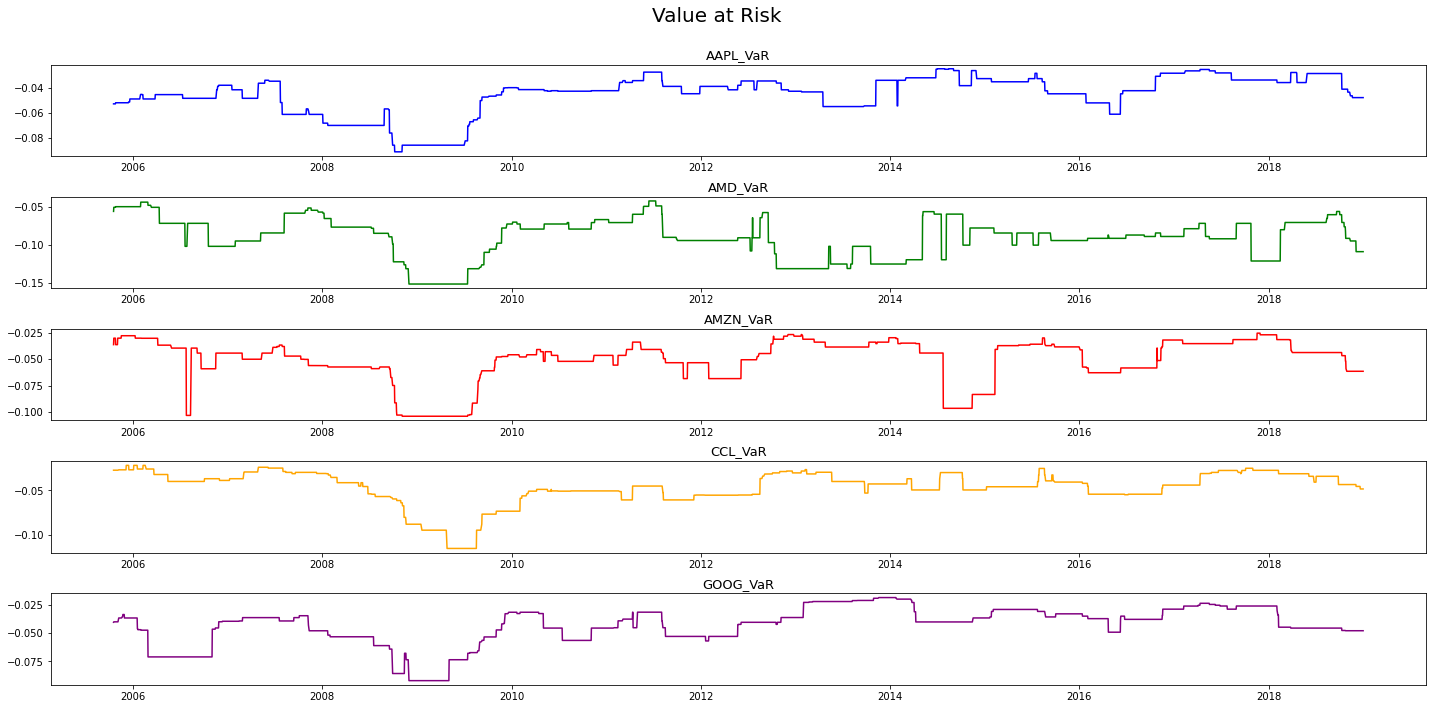

In [ ]:
fig, axes = plt.subplots(nrows=5, figsize=(20,10))

fig.suptitle('Value at Risk', size=20)

axes[0].plot(df.AAPL_VaR, color='blue')
axes[0].set_title('AAPL_VaR', fontsize=13)

axes[1].plot(df.AMD_VaR, color='green')
axes[1].set_title('AMD_VaR', fontsize=13)

axes[2].plot(df.AMZN_VaR, color='red')
axes[2].set_title('AMZN_VaR', fontsize=13)

axes[3].plot(df.CCL_VaR, color='orange')
axes[3].set_title('CCL_VaR', fontsize=13)

axes[4].plot(df.GOOG_VaR, color='purple')
axes[4].set_title('GOOG_VaR', fontsize=13)

plt.tight_layout()
fig.subplots_adjust(top=0.9)
plt.show()

สำหรับ CVaR สามารถเรียกอีกอย่างได้ว่า Expected ShortFall จึงสามารถใช้ funciton compute_esf เเล้วคำนวณเป็น rolling ได้

In [ ]:
df['AAPL_CVaR'] = df['AAPL_returns'].rolling(200).apply(compute_esf)
df['AMD_CVaR'] = df['AMD_returns'].rolling(200).apply(compute_esf)
df['AMZN_CVaR'] = df['AMZN_returns'].rolling(200).apply(compute_esf)
df['CCL_CVaR'] = df['CCL_returns'].rolling(200).apply(compute_esf)
df['GOOG_CVaR'] = df['GOOG_returns'].rolling(200).apply(compute_esf)

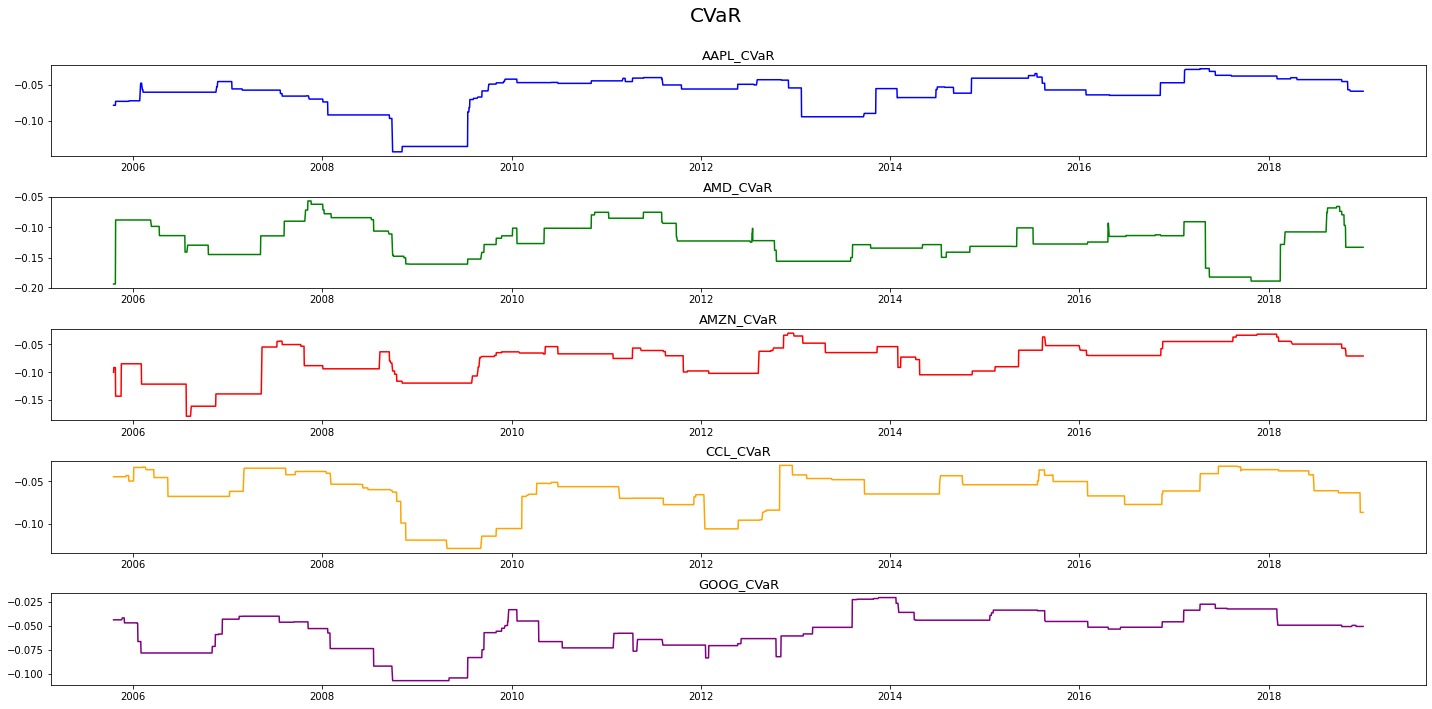

In [ ]:
fig, axes = plt.subplots(nrows=5, figsize=(20,10))

fig.suptitle('CVaR', size=20)

axes[0].plot(df.AAPL_CVaR, color='blue')
axes[0].set_title('AAPL_CVaR', fontsize=13)

axes[1].plot(df.AMD_CVaR, color='green')
axes[1].set_title('AMD_CVaR', fontsize=13)

axes[2].plot(df.AMZN_CVaR, color='red')
axes[2].set_title('AMZN_CVaR', fontsize=13)

axes[3].plot(df.CCL_CVaR, color='orange')
axes[3].set_title('CCL_CVaR', fontsize=13)

axes[4].plot(df.GOOG_CVaR, color='purple')
axes[4].set_title('GOOG_CVaR', fontsize=13)

plt.tight_layout()
fig.subplots_adjust(top=0.9)
plt.show()